In [2]:
!pip install xgboost
!pip install lightgbm

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, Ridge, RidgeClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor, StackingRegressor, StackingClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import make_scorer
from sklearn.base import RegressorMixin, ClassifierMixin, BaseEstimator
from sklearn.ensemble import VotingClassifier

from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Data Collection

In [8]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module6_exercise_train.csv')
download_file(test_data_url, 'module6_exercise_test.csv')

Downloaded module6_exercise_train.csv from https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_train.csv
Downloaded module6_exercise_test.csv from https://www.raphaelcousin.com/modules/module6/exercise/module6_exercise_test.csv


In [9]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
data_test = pd.read_csv('module6_exercise_test.csv', index_col='index')

### Data Analysis

In [5]:
data_train

,09_30_00,09_50_00,10_10_00,10_30_00,10_50_00,11_10_00,11_30_00,11_50_00,12_10_00,12_30_00,12_50_00,13_10_00,13_30_00,13_50_00,14_10_00,14_30_00,14_50_00,15_10_00,end_of_day_return
index,,,,,,,,,,,,,,,,,,,
0,-3.345378,0.471913,0.111795,0.897695,-1.836632,0.853765,-1.169854,-0.515758,-0.672838,0.737822,-0.110476,0.120739,0.658008,-0.033507,-0.809134,-0.286582,-0.431717,-0.094759,-0.741115
1,0.325809,0.367349,-0.048372,-1.513650,0.355659,-3.117421,-0.881352,-0.007122,0.243771,0.016151,0.114610,-0.604529,0.148780,-0.229934,-0.506916,-0.604501,-0.348392,0.318222,1.174188
2,1.105315,1.767107,0.053923,0.001599,1.120131,-0.358522,-1.279510,-0.229908,0.918732,0.486627,0.143440,0.201272,-0.166683,-0.701750,-0.431819,-0.418378,0.645661,0.389446,-1.583453
3,-0.139515,0.400993,1.376735,0.248226,0.896831,-0.064874,-0.546736,-0.596431,-0.261391,0.233740,-0.242694,-0.713535,-0.331204,0.165809,-0.330894,0.883535,0.907813,-0.191447,1.614671
4,6.826520,2.643832,-0.686910,-0.175818,0.418767,-0.550301,-0.002805,-0.272078,0.798230,-0.481628,0.281879,0.762998,2.641929,-2.324375,-0.402507,0.155151,-0.467507,-0.596658,1.183321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,-0.883029,0.062304,-0.297792,-0.512609,0.147675,0.128645,-0.722808,-0.112308,0.086121,-0.313414,0.407098,0.335073,0.681523,-0.380009,0.926100,-0.608350,0.619678,-0.334050,0.649858
3996,0.688887,-0.667074,0.346701,1.195935,-0.084245,0.007249,0.603659,-0.457421,0.383087,-0.004021,0.564976,0.397662,0.127530,0.412853,-0.078965,-0.017075,-0.219030,0.010699,0.487709
3997,0.246288,0.175187,0.463585,0.134366,-0.500703,1.491530,0.637691,0.048974,-0.218061,0.322912,-0.215735,-1.183474,-0.444753,0.468896,0.337624,0.367041,-0.318075,0.696240,0.111035


In [6]:
data_test

,09_30_00,09_50_00,10_10_00,10_30_00,10_50_00,11_10_00,11_30_00,11_50_00,12_10_00,12_30_00,12_50_00,13_10_00,13_30_00,13_50_00,14_10_00,14_30_00,14_50_00,15_10_00
index,,,,,,,,,,,,,,,,,,
9000,-0.090754,-1.786981,-0.470490,0.545190,1.048661,2.133359,0.769342,0.829361,0.329543,-0.260203,0.557235,0.052095,-0.083066,-0.910045,-0.956864,0.058267,-0.406571,-0.647216
9001,7.611001,0.247861,-2.001656,-0.804107,-0.473829,1.259438,0.195555,0.101885,-1.077060,0.573665,-0.434945,-0.183208,0.463489,-0.559725,0.091081,-0.084349,0.096026,0.091618
9002,1.150194,0.091151,2.545506,0.775302,-1.025222,-0.894295,-0.440365,0.671856,0.428863,0.485069,-0.782287,-0.352444,0.257920,0.526284,-0.029759,-0.797493,0.743176,-0.220204
9003,-0.884874,-1.103034,0.755916,-0.412053,0.178287,-0.104350,-0.212248,0.081726,0.380151,0.005660,-0.501693,0.817424,-0.470671,0.140688,1.406956,1.754916,0.261623,-0.495981
9004,-0.589833,0.379596,-0.545424,-0.217812,-0.730794,-0.480085,0.470663,1.298896,-0.710654,0.867138,1.515816,0.197528,0.756792,0.090558,-0.819575,0.136961,0.023876,-0.451478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.170209,-0.057276,-0.822165,-1.232996,-1.187110,0.179970,0.212011,-0.802815,-1.420647,1.098860,0.010170,-0.776480,-0.428853,-1.547797,-0.111830,0.130183,-1.493579,-0.862974
9996,0.527195,-1.883375,-1.468747,-0.749872,-0.541944,1.093662,-1.257120,-2.523593,-1.534209,0.226028,0.215094,0.414398,1.123071,-1.157484,0.673495,-0.318814,0.856825,0.579775
9997,0.342242,-1.807571,0.777167,-0.825105,0.058622,-1.090268,0.338895,0.130677,-0.234081,0.270528,-0.837228,-0.364189,0.379240,0.127673,-1.070985,0.662475,-0.409687,-0.223988


In [7]:
data_train.describe()

,09_30_00,09_50_00,10_10_00,10_30_00,10_50_00,11_10_00,11_30_00,11_50_00,12_10_00,12_30_00,12_50_00,13_10_00,13_30_00,13_50_00,14_10_00,14_30_00,14_50_00,15_10_00,end_of_day_return
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-0.141680,0.034964,0.020505,0.010436,-0.020574,0.002945,-0.010331,0.018534,0.005757,-0.016174,0.003401,-0.007827,0.009027,-0.021716,-0.018219,-0.019692,-0.012845,-0.005857,0.019466
std,5.257948,2.723808,1.352428,1.193797,1.066787,1.028344,0.980049,0.916572,0.793494,0.842957,0.748935,0.755444,0.742869,0.810765,0.743790,0.739733,0.735295,0.638472,0.962818
min,-153.020090,-14.173563,-11.462649,-8.014786,-6.884508,-6.174871,-7.197151,-12.981744,-5.170963,-10.867723,-5.270753,-6.466934,-3.780217,-7.522321,-3.853110,-4.318858,-6.421411,-3.553236,-8.210463
25%,-1.659958,-0.913043,-0.720355,-0.689361,-0.626834,-0.576174,-0.532172,-0.469984,-0.459903,-0.459817,-0.393010,-0.429838,-0.413955,-0.441057,-0.438892,-0.435665,-0.404864,-0.357411,-0.502152
50%,0.024667,-0.002644,0.008267,0.003442,-0.003890,-0.011194,-0.017745,0.014596,-0.010351,-0.034659,0.000475,-0.017674,0.004193,-0.015532,-0.030075,-0.031709,-0.007807,-0.004821,0.012860
75%,1.613584,0.925147,0.743400,0.680686,0.578904,0.582196,0.522556,0.492078,0.442551,0.413838,0.411547,0.397960,0.419423,0.412761,0.377625,0.391245,0.386953,0.342684,0.538451
max,42.788716,134.323450,10.271912,8.297362,12.070118,13.097849,10.406605,6.349618,4.765165,8.785591,7.543055,7.598514,5.996648,5.198389,6.403935,5.934699,5.290835,4.716630,11.468784


In [8]:
data_train.isnull().sum()

,0
09_30_00,0
09_50_00,0
10_10_00,0
10_30_00,0
10_50_00,0
11_10_00,0
11_30_00,0
11_50_00,0
12_10_00,0
12_30_00,0


In [9]:
data_test.isnull().sum()

,0
09_30_00,0
09_50_00,0
10_10_00,0
10_30_00,0
10_50_00,0
11_10_00,0
11_30_00,0
11_50_00,0
12_10_00,0
12_30_00,0


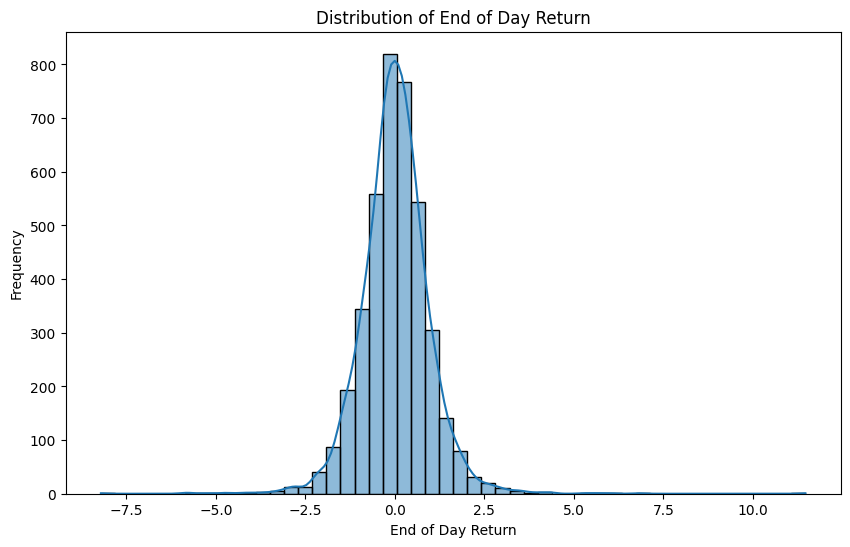

In [10]:
# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data_train['end_of_day_return'], bins=50, kde=True)
plt.title('Distribution of End of Day Return')
plt.xlabel('End of Day Return')
plt.ylabel('Frequency')
plt.show()

### Model Building and Evaluate

In [10]:
y = data_train.pop('end_of_day_return')
X = data_train.copy()

In [14]:
def weighted_accuracy(y_true, y_pred):
    weights = np.abs(y_true)

    # Compute the sign of true and predicted values
    sign_true = np.sign(y_true)
    sign_pred = np.sign(y_pred)

    # Correct predictions where the sign of the true and predicted values match
    correct_predictions = sign_true == sign_pred

    # Compute the weighted accuracy
    weighted_acc = np.sum(weights * correct_predictions) / np.sum(weights)

    return weighted_acc

In [13]:
# Function to plot the evaluation results
def plot_results(mse_train, mse_test, w_acc_train, w_acc_test):
    plt.figure(figsize=(12, 6))

    # MSE plot
    plt.subplot(1, 2, 1)
    plt.plot(mse_train, label="Train MSE", marker='o')
    plt.plot(mse_test, label="Test MSE", marker='o')
    plt.fill_between(range(len(mse_train)), np.min(mse_train), np.max(mse_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(mse_test)), np.min(mse_test), np.max(mse_test), color='orange', alpha=0.1)
    plt.title("MSE over Folds")
    plt.xlabel("Fold")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    # weighted_accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(w_acc_train, label="Train weighted_accuracy", marker='o')
    plt.plot(w_acc_test, label="Test weighted_accuracy", marker='o')
    plt.fill_between(range(len(w_acc_train)), np.min(w_acc_train), np.max(w_acc_train), color='blue', alpha=0.1)
    plt.fill_between(range(len(w_acc_test)), np.min(w_acc_test), np.max(w_acc_test), color='orange', alpha=0.1)
    plt.title("weighted_accuracy over Folds")
    plt.xlabel("Fold")
    plt.ylabel("weighted_accuracy")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

def plot_multi_model_results(results):
    # Set up the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20))

    # Colors for train and test
    train_color = 'skyblue'
    test_color = 'lightgreen'

    # Plot MSE
    ax1.set_title('Mean Squared Error (MSE) Comparison', fontsize=16)
    ax1.set_ylabel('MSE', fontsize=12)
    ax1.set_xlabel('Models', fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)

    # Plot weighted_accuracy
    ax2.set_title('weighted_accuracy Comparison', fontsize=16)
    ax2.set_ylabel('weighted_accuracy', fontsize=12)
    ax2.set_xlabel('Models', fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)

    x = np.arange(len(results))
    width = 0.35

    for i, (model_name, scores) in enumerate(results.items()):
        # MSE
        mse_train = scores['mse_train']
        mse_test = scores['mse_test']

        ax1.bar(x[i] - width/2, np.mean(mse_train), width, label='Train' if i == 0 else "",
                color=train_color, alpha=0.7)
        ax1.bar(x[i] + width/2, np.mean(mse_test), width, label='Test' if i == 0 else "",
                color=test_color, alpha=0.7)

        ax1.errorbar(x[i] - width/2, np.mean(mse_train),
                     yerr=[[np.mean(mse_train)-np.min(mse_train)], [np.max(mse_train)-np.mean(mse_train)]],
                     fmt='none', ecolor='black', capsize=5)
        ax1.errorbar(x[i] + width/2, np.mean(mse_test),
                     yerr=[[np.mean(mse_test)-np.min(mse_test)], [np.max(mse_test)-np.mean(mse_test)]],
                     fmt='none', ecolor='black', capsize=5)

        # weighted_accuracy
        w_acc_train = scores['w_acc_train']
        w_acc_test = scores['w_acc_test']

        ax2.bar(x[i] - width/2, np.mean(w_acc_train), width, label='Train' if i == 0 else "",
                color=train_color, alpha=0.7)
        ax2.bar(x[i] + width/2, np.mean(w_acc_test), width, label='Test' if i == 0 else "",
                color=test_color, alpha=0.7)

        ax2.errorbar(x[i] - width/2, np.mean(w_acc_train),
                     yerr=[[np.mean(w_acc_train)-np.min(w_acc_train)], [np.max(w_acc_train)-np.mean(w_acc_train)]],
                     fmt='none', ecolor='black', capsize=5)
        ax2.errorbar(x[i] + width/2, np.mean(w_acc_test),
                     yerr=[[np.mean(w_acc_test)-np.min(w_acc_test)], [np.max(w_acc_test)-np.mean(w_acc_test)]],
                     fmt='none', ecolor='black', capsize=5)

    ax1.set_xticks(x)
    ax1.set_xticklabels(results.keys(), rotation=45, ha='right')
    ax2.set_xticks(x)
    ax2.set_xticklabels(results.keys(), rotation=45, ha='right')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

#### Simple Baseline

In [14]:
# Function to handle train-test evaluation in a fold
def train_and_evaluate(X_train, X_test, y_train, y_test, model):

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on train set
    y_pred_train = model.predict(X_train)
    # Make predictions on train set
    y_pred_test = model.predict(X_test)

    # Compute MSE for train and test
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test = mean_squared_error(y_test, y_pred_test)

    # Compute weighted_accuracy

    w_acc_train = weighted_accuracy(y_train, y_pred_train)
    w_acc_test = weighted_accuracy(y_test, y_pred_test)

    return mse_train, mse_test, w_acc_train, w_acc_test


def run_multi_model_cv(X, y, models, n_splits=5):
    fold = KFold(n_splits=n_splits)
    results = {name: {'mse_train': [], 'mse_test': [], 'w_acc_train': [], 'w_acc_test': []}
               for name in models.keys()}

    for train_index, test_index in fold.split(X, y):
        X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()

        for name, model in models.items():
            mse_train, mse_test, w_acc_train, w_acc_test = train_and_evaluate(
                X_train, X_test, y_train, y_test, model
            )
            results[name]['mse_train'].append(mse_train)
            results[name]['mse_test'].append(mse_test)
            results[name]['w_acc_train'].append(w_acc_train)
            results[name]['w_acc_test'].append(w_acc_test)
        # Find the model with the best mean w_acc test score
    best_mean_w_acc = -1
    best_model = None
    best_min_w_acc = None
    best_max_w_acc = None

    for name, result in results.items():
        w_acc_test_scores = result['w_acc_test']
        mean_w_acc_test = sum(w_acc_test_scores) / len(w_acc_test_scores)  # Calculate mean w_acc score
        min_w_acc_test = min(w_acc_test_scores)  # Minimum w_acc score
        max_w_acc_test = max(w_acc_test_scores)  # Maximum w_acc score

        if mean_w_acc_test > best_mean_w_acc:
            best_mean_w_acc = mean_w_acc_test
            best_min_w_acc = min_w_acc_test
            best_max_w_acc = max_w_acc_test
            best_model = name

    # Print the best mean w_acc test score, min, max, and the associated model
    print(f"Best mean w_acc test score: {best_mean_w_acc:.4f} by model: {best_model}")
    print(f"Min w_acc test score: {best_min_w_acc:.4f}, Max w_acc test score: {best_max_w_acc:.4f}")
    return results


In [15]:
# Step 1: Run cross-validation
results = run_multi_model_cv(X, y, {"RandomForestRegressor": RandomForestRegressor(n_jobs=-1)})

Best mean w_acc test score: 0.5151 by model: RandomForestRegressor
Min w_acc test score: 0.4750, Max w_acc test score: 0.5526


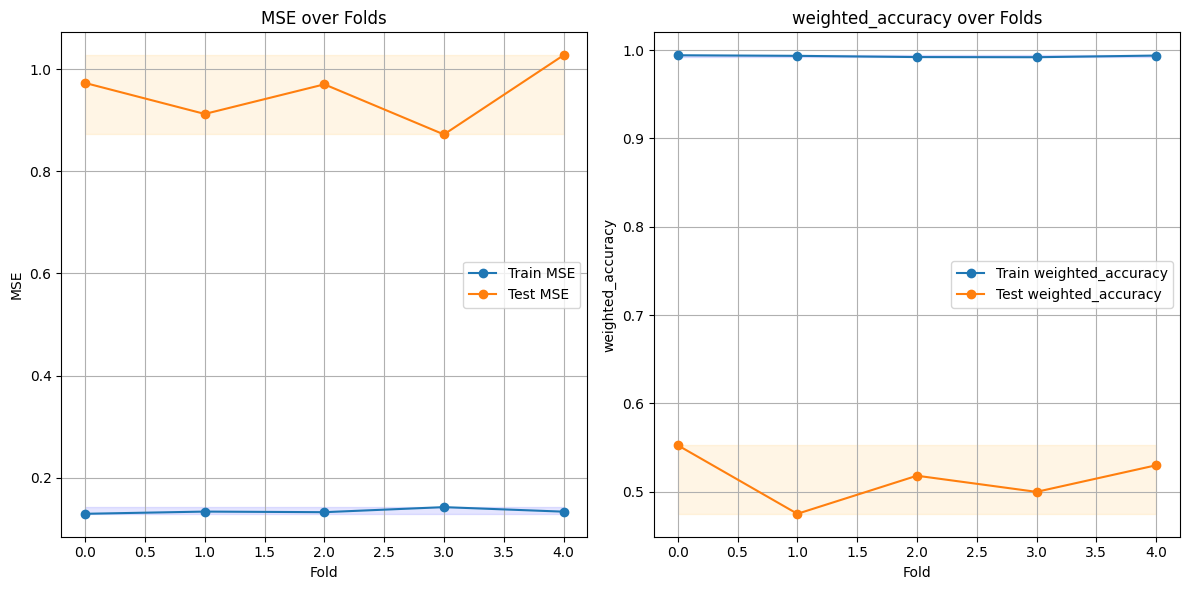

In [16]:
# Step 2: Plot the results
plot_results(results["RandomForestRegressor"]["mse_train"],
             results["RandomForestRegressor"]["mse_test"],
             results["RandomForestRegressor"]["w_acc_train"],
             results["RandomForestRegressor"]["w_acc_test"])

In [17]:
models = {
    'Ridge': Ridge(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'SVR': SVR(),
    'Lasso': Lasso(max_iter=5000),
    'KNN Regressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor(),
    'LGBMRegressor': LGBMRegressor(verbose=-1)
}

In [18]:
# Run cross-validation for regression models
results = run_multi_model_cv(X, y, models)

Best mean w_acc test score: 0.5323 by model: Random Forest Regressor
Min w_acc test score: 0.5055, Max w_acc test score: 0.5526


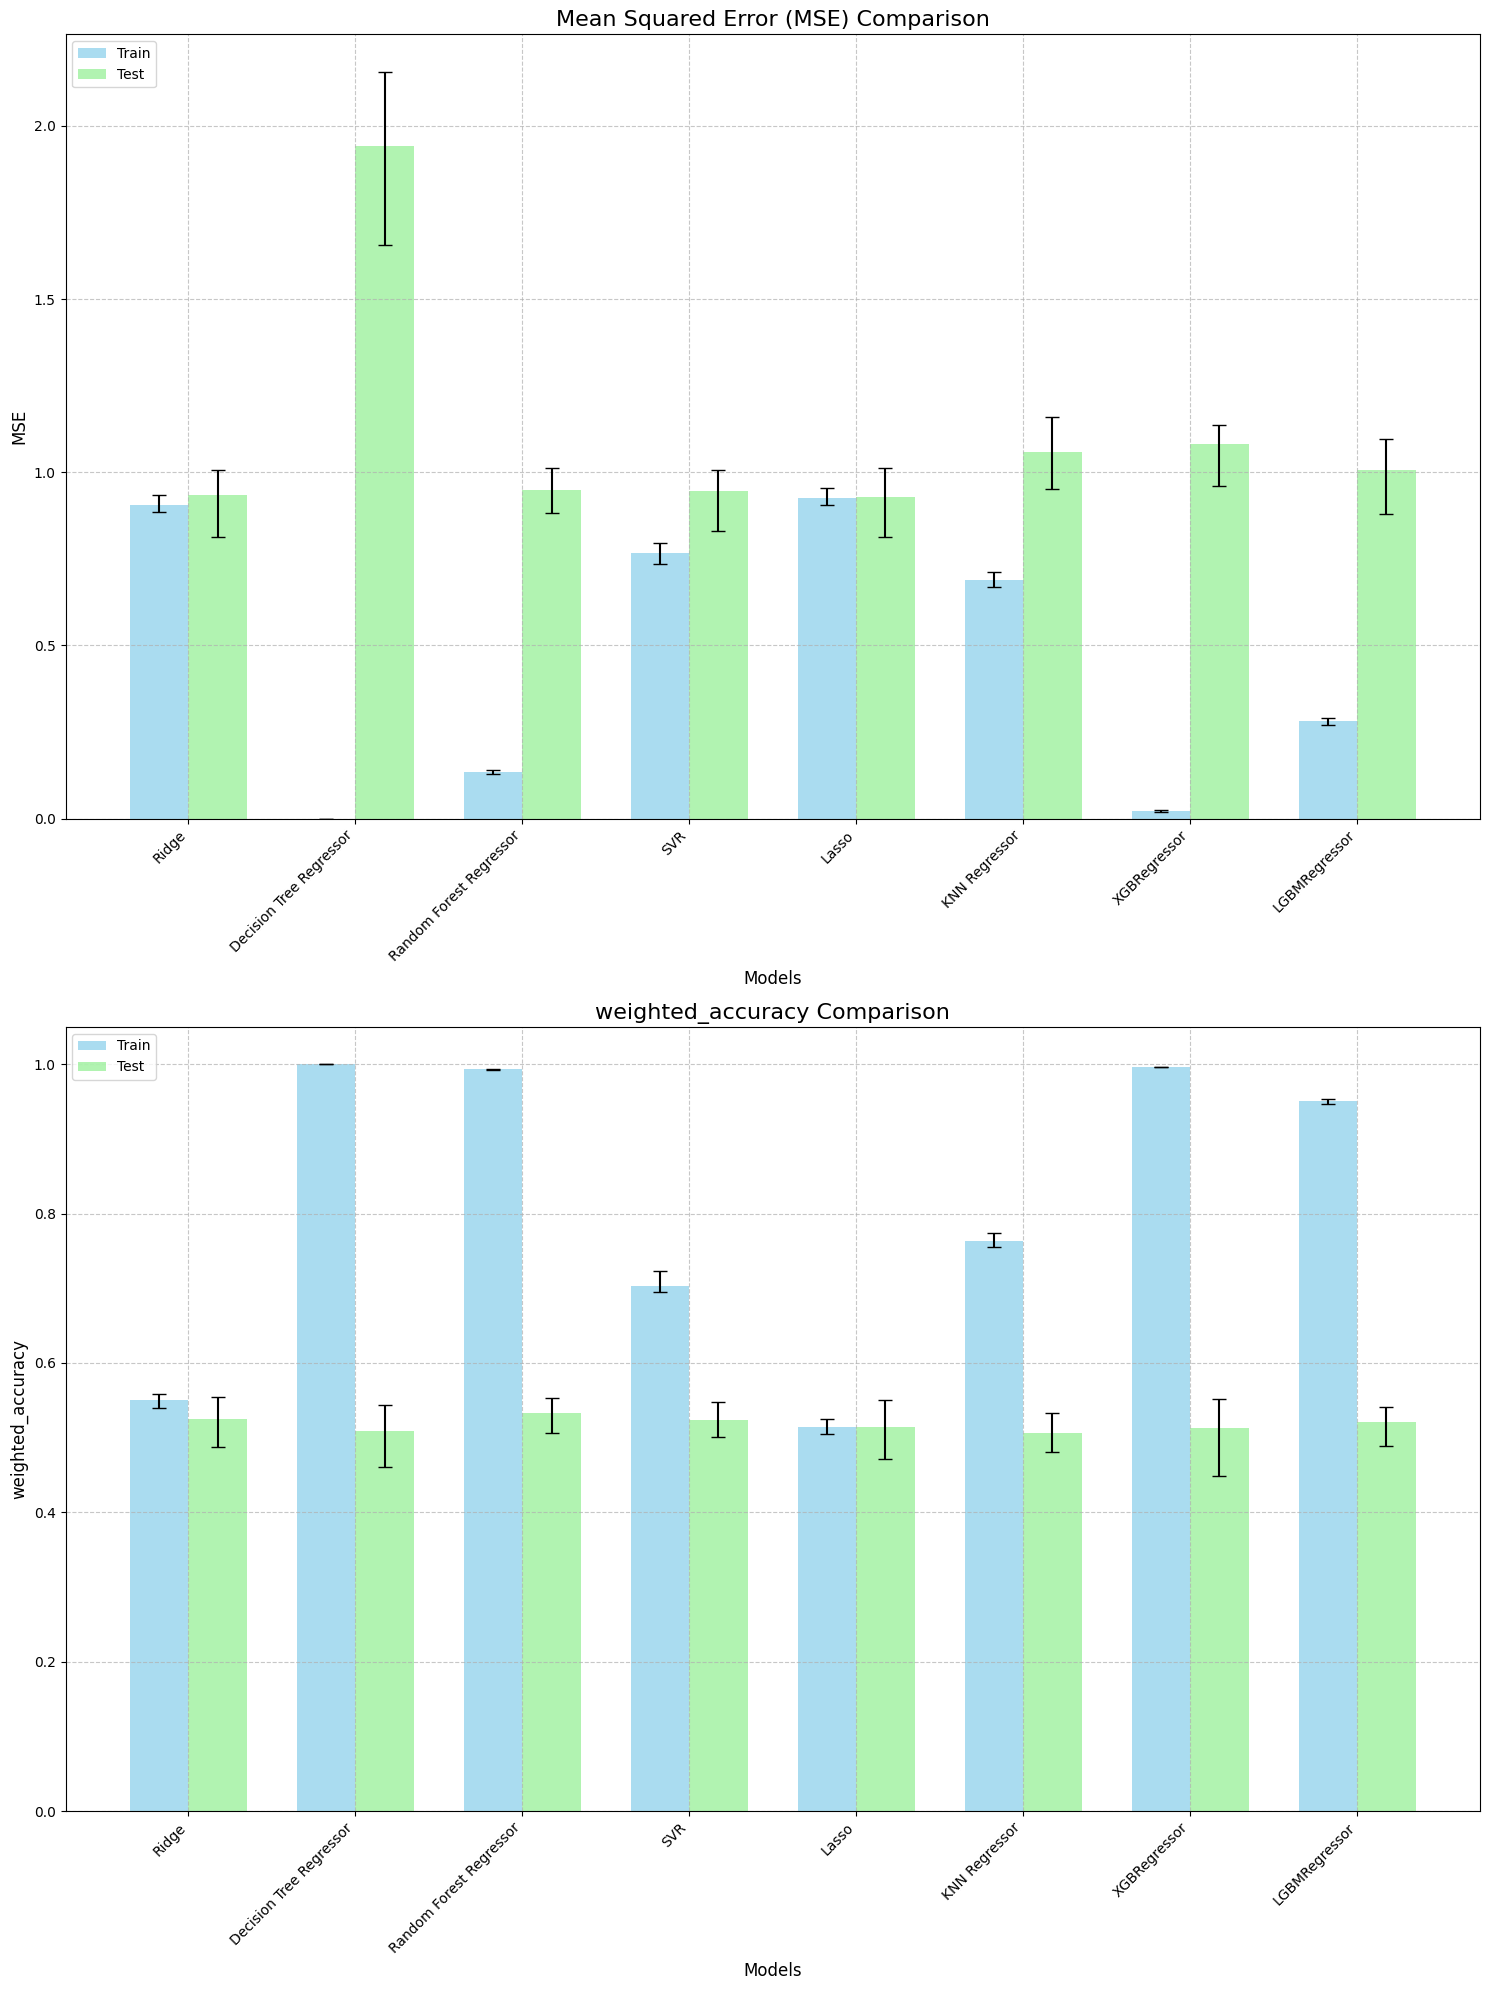

In [19]:
# Plot MSE results for regression models
plot_multi_model_results(results)

#### Manage properly the objective weighted_accuracy
should we create different classes? custom loss?

Create Compare and Optimize different models

#### Optimize

In [20]:
!pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 2.8 MB/s eta 0:00:00


In [21]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from skopt.callbacks import DeltaYStopper

# Define the search spaces for each model
spaces = {
    'RandomForestRegressor': {
        'n_estimators': Integer(10, 200),
        'max_depth': Integer(1, 20),
        'min_samples_split': Integer(2, 20),
        'min_samples_leaf': Integer(1, 20)
    },
    'XGBRegressor': {
        'n_estimators': Integer(10, 100),
        'max_depth': Integer(1, 50),
        'learning_rate': Real(0.01, 2.0, 'log-uniform'),
        'subsample': Real(0.5, 1.0, 'uniform'),
        'colsample_bytree': Real(0.5, 1.0, 'uniform')
    },
#
    'SVR': {
        'C': Real(0.1, 10.0, 'log-uniform'),
        'epsilon': Real(0.001, 1.0, 'log-uniform'),
        'kernel': Categorical(['linear', 'rbf', 'poly'])
    },
    'KNNRegressor': {
        'n_neighbors': Integer(1, 20),
        'weights': Categorical(['uniform', 'distance']),
        'p': Integer(1, 2)
    },
    'Lasso': {
        'alpha': Real(0.0001, 5.0, 'log-uniform')
    },
    'Ridge': {
        'alpha': Real(0.01, 5.0, 'log-uniform'),
    },
}

def optimizer_callback(res):
    if len(res.func_vals) % 10 == 0:  # Print every 5 iterations
        print(f"Iteration {len(res.func_vals)}: Best score = {-res.fun:.4f}")

delta_stopper = DeltaYStopper(delta=0.001, n_best=10)

# Function to optimize models
def optimize_model(X, y, model, space, n_iter=100):
    sfold = KFold(n_splits=5)

    scorer = make_scorer(weighted_accuracy, greater_is_better=True)

    opt = BayesSearchCV(
        model,
        space,
        n_iter=n_iter,
        n_points=5,
        cv=sfold,
        n_jobs=-1,
        scoring=scorer,
        random_state=42
    )

    opt.fit(X, y, callback=[optimizer_callback, delta_stopper])

    return opt

# Optimize models
models = {
    'RandomForestRegressor': RandomForestRegressor(),
    'XGBRegressor': XGBRegressor(),
    'SVR': SVR(),
    'KNNRegressor': KNeighborsRegressor(),
    'Lasso': Lasso(max_iter=1000),
    'Ridge': Ridge(),
}

In [22]:
models_opt = {}

for model_name, model in models.items():
    print(f"Optimizing {model_name}...")
    optimized_model = optimize_model(X, y, model, spaces[model_name])
    models_opt[model_name] = optimized_model
    print(f"Best parameters: {optimized_model.best_params_}")
    print(f"Best score: {optimized_model.best_score_:.4f}")
    print()


Optimizing RandomForestRegressor...
Iteration 10: Best score = 0.5264
Iteration 20: Best score = 0.5345
Iteration 30: Best score = 0.5408
Iteration 40: Best score = 0.5408
Iteration 50: Best score = 0.5408
Iteration 60: Best score = 0.5408
Iteration 70: Best score = 0.5408
Iteration 80: Best score = 0.5408
Iteration 90: Best score = 0.5408
Iteration 100: Best score = 0.5408
Best parameters: OrderedDict([('max_depth', 16), ('min_samples_leaf', 20), ('min_samples_split', 3), ('n_estimators', 10)])
Best score: 0.5408

Optimizing XGBRegressor...
Iteration 10: Best score = 0.5294
Iteration 20: Best score = 0.5294
Iteration 30: Best score = 0.5294
Iteration 40: Best score = 0.5294
Iteration 50: Best score = 0.5294
Iteration 60: Best score = 0.5294
Iteration 70: Best score = 0.5294
Iteration 80: Best score = 0.5406
Iteration 90: Best score = 0.5406
Iteration 100: Best score = 0.5406
Best parameters: OrderedDict([('colsample_bytree', 0.9636304055981109), ('learning_rate', 0.026676931350921498)

/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [3, 1, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [4, 1, 'uniform']
  warnings.warn(


Iteration 60: Best score = 0.5272


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'distance'] before, using random point [6, 2, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'distance'] before, using random point [7, 2, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [9, 1, 'distance'] before, using random point [13, 1, 'distance']
  warnings.warn(


Iteration 70: Best score = 0.5272
Iteration 80: Best score = 0.5272


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 1, 'distance'] before, using random point [9, 2, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'distance'] before, using random point [3, 2, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [13, 1, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [7, 1, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, 

Iteration 90: Best score = 0.5272


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [7, 1, 'distance'] before, using random point [8, 1, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [3, 1, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [20, 2, 'uniform']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, using random point [8, 1, 'distance']
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [10, 1, 'uniform'] before, u

Iteration 100: Best score = 0.5272
Best parameters: OrderedDict([('n_neighbors', 10), ('p', 1), ('weights', 'distance')])
Best score: 0.5272

Optimizing Lasso...
Iteration 10: Best score = 0.5241
Iteration 20: Best score = 0.5283
Iteration 30: Best score = 0.5283
Iteration 40: Best score = 0.5289
Iteration 50: Best score = 0.5289
Iteration 60: Best score = 0.5289
Iteration 70: Best score = 0.5289
Iteration 80: Best score = 0.5294
Iteration 90: Best score = 0.5294
Iteration 100: Best score = 0.5294
Best parameters: OrderedDict([('alpha', 0.01640191281874959)])
Best score: 0.5294

Optimizing Ridge...
Iteration 10: Best score = 0.5254
Best parameters: OrderedDict([('alpha', 0.12789638921577903)])
Best score: 0.5254



In [39]:
models = {}
for name, opt in models_opt.items():
    model_class = type(opt.best_estimator_)  # Get the model class (e.g., RandomForestRegressor)
    best_params = opt.best_params_ # Get the best parameters from the optimization

    # Add the model with the best parameters to the new dictionary
    models[f"{name} opt"] = model_class(**best_params)

results = run_multi_model_cv(X, y, models)

KeyboardInterrupt: 

#### Bagging

In [24]:
from sklearn.ensemble import VotingRegressor

In [29]:
# Sort the models by their best score in descending order
top_models = sorted(models_opt.items(), key=lambda x: x[1].best_score_, reverse=True)

# Filter only regressors from the sorted models
top_2_regressors = [(name, opt.best_estimator_) for name, opt in top_models if isinstance(opt.best_estimator_, RegressorMixin)][:2]

# Print the top 2 regressors for verification
print("Top 2 regressors used in VotingRegressor:")
for name, estimator in top_2_regressors:
    print(f"{name}: {type(estimator).__name__}")

# Define the voting ensemble using the top 2 regressors
voting_regressor_ensemble = VotingRegressor(estimators=top_2_regressors)


bagging_ensemble = BaggingRegressor(
    estimator=XGBRegressor(),
    n_estimators=10,
    max_samples=0.8,
    max_features=0.8,
    bootstrap=True,
    bootstrap_features=False,
    n_jobs=-1
)

Top 2 regressors used in VotingRegressor:
RandomForestRegressor: RandomForestRegressor
XGBRegressor: XGBRegressor


In [30]:
models = {
    'bagging_ensemble': bagging_ensemble,
    'voting_regressor_ensemble': voting_regressor_ensemble,
    'Random Forest Baseline': RandomForestRegressor(),
}

results = run_multi_model_cv(X, y, models)

Best mean w_acc test score: 0.5290 by model: voting_regressor_ensemble
Min w_acc test score: 0.4811, Max w_acc test score: 0.5520


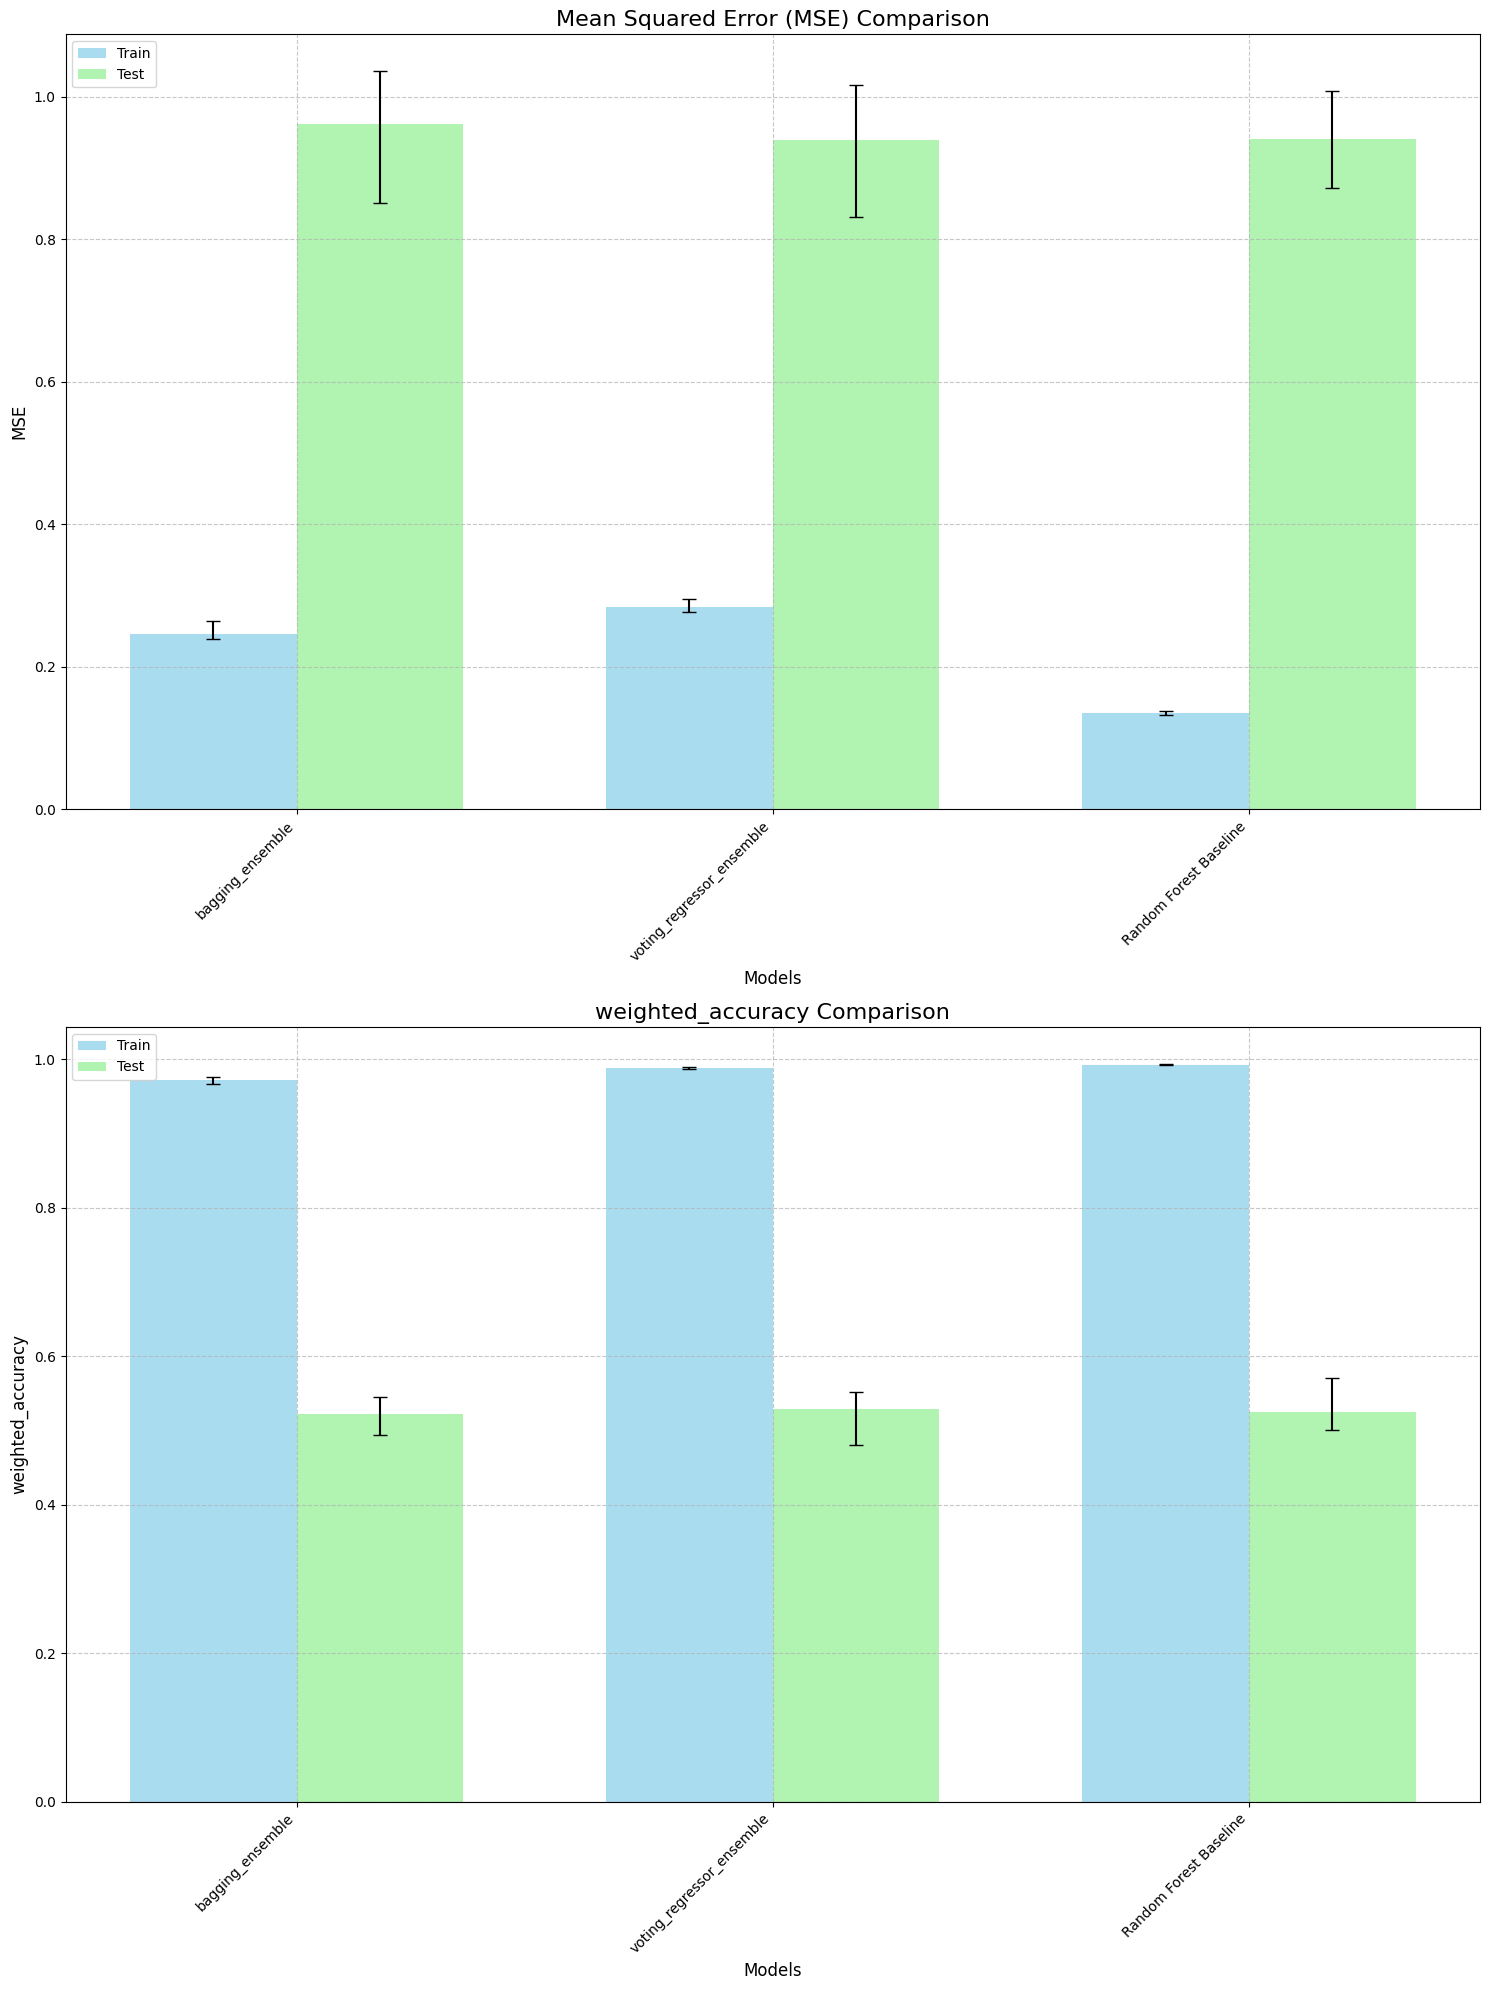

In [31]:
plot_multi_model_results(results)

#### Stacking

In [32]:
# Separate regressors and classifiers from models_opt
regressor_estimators = [(name, opt.best_estimator_) for name, opt in models_opt.items() if isinstance(opt.best_estimator_, RegressorMixin)]

# Define the meta-models
ridge_regressor = Ridge()
random_forest_regressor = RandomForestRegressor()
xgb_regressor = XGBRegressor()

# Stacking Regressor with Ridge as meta-model
stacking_regressor_ridge = StackingRegressor(
    estimators=regressor_estimators,
    final_estimator=ridge_regressor
)

# Stacking Regressor with RandomForest as meta-model
stacking_regressor_rf = StackingRegressor(
    estimators=regressor_estimators,
    final_estimator=random_forest_regressor
)

# Stacking Regressor with XGBRegressor as meta-model
stacking_regressor_xgb = StackingRegressor(
    estimators=regressor_estimators,
    final_estimator=xgb_regressor
)

In [33]:
models = {
    'Stacking Regressor (Ridge Meta)': stacking_regressor_ridge,
    'Stacking Regressor (RandomForest Meta)': stacking_regressor_rf,
    'Stacking Regressor (XGBRegressor Meta)': stacking_regressor_xgb,
}

# Run cross-validation for all models
results = run_multi_model_cv(X, y, models)

Best mean w_acc test score: 0.5262 by model: Stacking Regressor (Ridge Meta)
Min w_acc test score: 0.4934, Max w_acc test score: 0.5895


### Submission:

In [11]:
data_train = pd.read_csv('module6_exercise_train.csv', index_col='index')
X_test = pd.read_csv('module6_exercise_test.csv', index_col='index')
y_train = data_train.pop('end_of_day_return')
X_train = data_train.copy()

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from collections import OrderedDict

In [17]:
# Train on complete data (X_train, y_train) and predict on X_test
best_params = OrderedDict([('colsample_bytree', 0.9636304055981109), ('learning_rate', 0.026676931350921498), ('max_depth', 45), ('n_estimators', 100), ('subsample', 0.8471728924717585)])

best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)

cv = cross_validate(best_model, X_train, y_train, cv=5, scoring=make_scorer(weighted_accuracy))

y_pred = best_model.predict(X_test)

In [18]:
print(cv['test_score'].mean())

0.5405744934272724


In [20]:

submission = pd.DataFrame({
    'index': X_test.index,
    'end_of_day_return': y_pred
})

submission.to_csv('submission.csv', index=False, sep=',')